In [1]:
import os

from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from sdm_eurec4a.visulization import set_custom_rcParams, adjust_lightness_array

from sdm_eurec4a.identifications import match_clouds_and_cloudcomposite, match_clouds_and_dropsondes

from sdm_eurec4a import get_git_revision_hash, RepositoryPath

In [2]:
plt.style.use("default")
default_colors = set_custom_rcParams()
darker_colors = adjust_lightness_array(default_colors, 0.75)

REPOSITORY_ROOT = RepositoryPath("levante").get_repo_dir()

output_dir = REPOSITORY_ROOT / Path("data/model/input_examples/")
# output_dir.mkdir(parents=True, exist_ok=True)

fig_path = REPOSITORY_ROOT / Path("results/compare_cluster_and_clouds/")
fig_path.mkdir(parents=True, exist_ok=True)


In [3]:
clusters = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/cloud_composite/processed/identified_clouds/identified_clusters_rain_mask_5.nc")
)
clouds = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/cloud_composite/processed/identified_clouds/identified_clouds_rain_mask.nc")
)

# select only clouds which are between 800 and 1100 m
clouds = clouds.where(
    (clouds.alt >= 300) 
    & (clouds.alt <= 1100)
    & (clouds.vertical_extent < 100),
    drop=True
)
clusters = clusters.where(
    (clusters.alt >= 300) 
    & (clusters.alt <= 1100)
    & (clusters.vertical_extent < 100),
    drop=True
)

distance_clouds = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(f"data/observation/combined/distance/distance_dropsondes_identified_clouds_rain_mask.nc")
)

distance_clusters = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(f"data/observation/combined/distance/distance_dropsondes_identified_clusters_rain_mask_5.nc")
)

cloud_composite = xr.open_dataset(
    REPOSITORY_ROOT / Path("data/observation/cloud_composite/processed/cloud_composite_si_units.nc"),
    chunks={"time": 1000},
)


drop_sondes = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/dropsonde/processed/drop_sondes.nc")
)

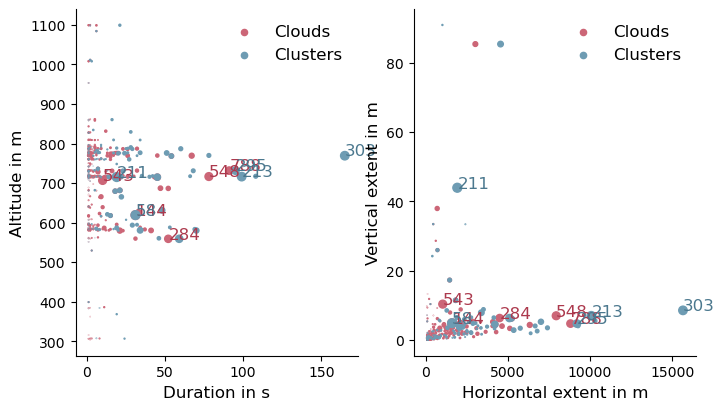

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].scatter(
    clouds["duration"].dt.seconds,
    clouds["alt"],
    clouds["liquid_water_content"],
    marker="o",
    linestyle="None",
    color=default_colors[0],
    label = "Clouds",
)
axs[0].scatter(
    clusters["duration"].dt.seconds,
    clusters["alt"],
    clusters["liquid_water_content"],
    marker="o",
    linestyle="None",
    color=default_colors[1],
    label = "Clusters",
)
axs[0].set_xlabel("Duration in s")
axs[0].set_ylabel("Altitude in m")
# axs[0].set_title("LWC in kg/kg")


axs[1].scatter(
    clouds["horizontal_extent"],
    clouds["vertical_extent"],
    clouds["liquid_water_content"],
    marker="o",
    linestyle="None",
    color=default_colors[0],
    label = "Clouds",
)
axs[1].scatter(
    clusters["horizontal_extent"],
    clusters["vertical_extent"],
    clusters["liquid_water_content"],
    marker="o",
    linestyle="None",
    color=default_colors[1],
    label = "Clusters",
)
axs[1].set_xlabel("Horizontal extent in m")
axs[1].set_ylabel("Vertical extent in m")
# axs[1].set_title("LWC in kg/kg")

for ax in axs.flatten():
    ax.legend() 

annotation_number = 5

for t in clouds.sortby("liquid_water_content").time[-annotation_number:]:
    subdata = clouds.sel(time=t)
    axs[0].annotate(subdata.cloud_id.data, (subdata.duration.dt.seconds, subdata.alt),
    color=darker_colors[0],
    )
    axs[1].annotate(subdata.cloud_id.data, (subdata["horizontal_extent"], subdata["vertical_extent"]),
    color=darker_colors[0],
    )
for t in clusters.sortby("liquid_water_content").time[-annotation_number:]:
    subdata = clusters.sel(time=t)
    axs[0].annotate(
        subdata.cloud_id.data, (subdata.duration.dt.seconds, subdata.alt),
        color=darker_colors[1],
    )
        
    axs[1].annotate(subdata.cloud_id.data, (subdata["horizontal_extent"], subdata["vertical_extent"]),
    color=darker_colors[1],
    )
# fig.savefig(fig_path / Path("cloud_properties.png"))

In [5]:
import pandas as pd

In [6]:
from sdm_eurec4a.identifications import select_individual_cloud_by_id

select_individual_cloud_by_id(clusters, chosen_id=213).time

<xarray.DataArray 'time' (time: 1)>
array(['2020-02-11T07:59:16.500000000'], dtype='datetime64[ns]')
Coordinates:
    cloud_id  (time) int64 213
  * time      (time) datetime64[ns] 2020-02-11T07:59:16.500000
Attributes:
    long_name:  mid time of cloud event

In [9]:
time_slice = slice(
    pd.to_datetime('2020-02-11 T 07:57'),
    # pd.to_datetime("2020-02-11 T 07:57:40")
    pd.to_datetime("2020-02-11 T 08:01")
)

example_cloud = clouds.sel(time = time_slice)
example_cluster = clusters.sel(time = time_slice)

cloud_ATR = match_clouds_and_cloudcomposite(
    example_cloud, cloud_composite
)

cluster_ATR = match_clouds_and_cloudcomposite(
    example_cluster, cloud_composite
)


full_ATR = cloud_composite.sel(time = time_slice)

AttributeError: Axes.set() got an unexpected keyword argument 'axis'

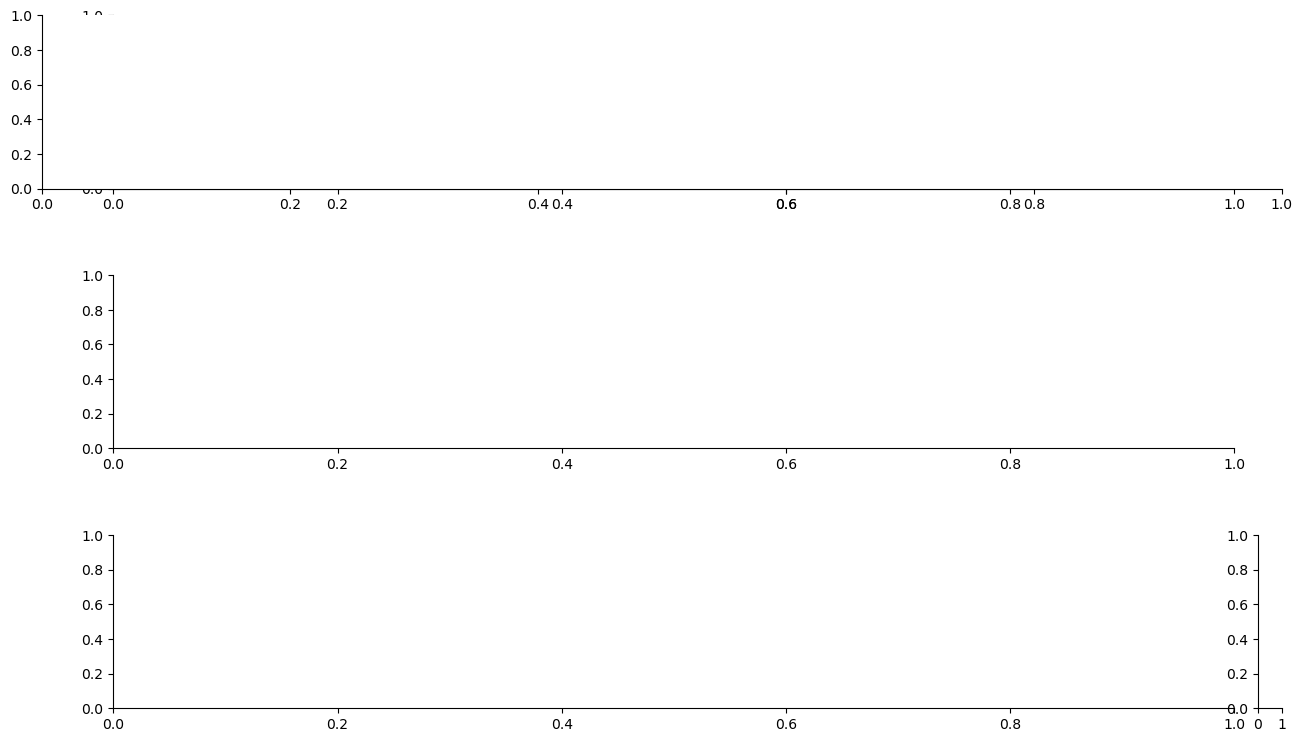

In [ ]:
fig = plt.figure(figsize=(16, 9))
outer_grid = fig.add_gridspec(ncols=52, nrows = 3, wspace=0, hspace=0.5)

ax1 = fig.add_subplot(outer_grid[0, 3:50])
ax2 = fig.add_subplot(outer_grid[1, 3:50], sharex=ax1, sharey = ax1)
ax3 = fig.add_subplot(outer_grid[2, 3:50], sharex=ax1)
cax = fig.add_subplot(outer_grid[2, 51])
ax = fig.add_subplot(outer_grid[0, :])

ax1_title = fig.add_subplot(outer_grid[0, :], frame_on=False)
ax1_title.axis('off')
ax1_title.set_ylabel("Clouds", fontsize = 16)

ax1.scatter(cloud_ATR.time, cloud_ATR.alt, marker = '.', color = darker_colors[0], label = "ATR measurments")
ax2.scatter(cluster_ATR.time, cluster_ATR.alt, marker = '.', color = darker_colors[1], label = "ATR measurments")
yvalues = [700, 760]

for t, s, e in zip(example_cloud.time, example_cloud.start, example_cloud.end) :
    line = ax1.axvline(t.data, ymin= 0, ymax = 1, color = darker_colors[0], linewidth = 1, linestyle = "--")
    fill = ax1.fill_betweenx(yvalues, s.data, e.data, color = default_colors[0], alpha = 0.5)
line.set_label('Mid time')
fill.set_label('Duration')
for t, s, e in zip(example_cluster.time, example_cluster.start, example_cluster.end) :
    line = ax2.axvline(t.data, ymin= 0, ymax = 1, color = darker_colors[1], linewidth = 1, linestyle = "--")
    fill = ax2.fill_betweenx(yvalues, s.data, e.data, color = default_colors[1], alpha = 0.5)
line.set_label('Mid time')
fill.set_label('Duration')

ax1.set_title("Identified Clouds", y=1.0, pad=-14)
ax1.set_ylabel("Altitude in m")
ax1.legend()
ax2.set_title("Identified Cloud Clusters", y=1.0, pad=-14)
ax2.set_ylabel("Altitude in m")
ax2.legend()

vmin, vmax = 1, 1e8
pm = ax3.pcolormesh(
    full_ATR.time,
    full_ATR.radius,
    full_ATR.particle_size_distribution,
    cmap = "Greys",
    norm = mpl.colors.LogNorm(vmin, vmax),
)
split_radius = 4.5e-5
ax3.axhline(split_radius, color = "r", linestyle = "--", linewidth = 1, label ="Split between cloud and rain droplets")

ax3.set_yscale("log")
ax3.set_xlabel("Time")
ax3.set_ylabel("Radius in m")
ax3.set_title("PSD over time", y=1.0, pad=-14)
ax3.legend()
fig.colorbar(pm, cax = cax , orientation = "vertical", label = r"Drop counts in #$/m^{-3}$")


fig.suptitle(f"Example Cloud and Cluster identification from {time_slice.start.date()}")

In [46]:
print(time_slice.start.date())

2020-02-11


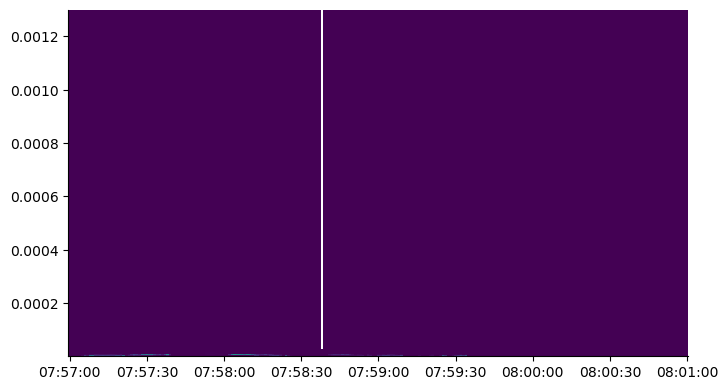

In [72]:


plt.pcolormesh(
    full_ATR.time,
    full_ATR.radius,
    full_ATR.particle_size_distribution,
)

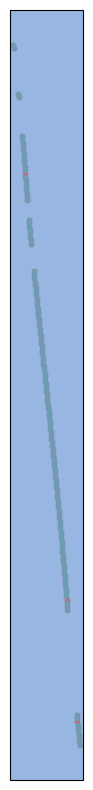

In [31]:
# Create a new figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Set the extent of the map
# example_cloud = clouds.sel(time = time_slice)

# Add your data layers or plot your data here

# ax.set_extent([example_cloud.lon.min(), example_cloud.lon.max(), example_cloud.lat.min(), example_cloud.lat.max()])

ax.scatter(cluster_ATR.lon, cluster_ATR.lat, marker = '.')
ax.scatter(cloud_ATR.lon, cloud_ATR.lat, marker = '.')

In [ ]:

example_cloud = clouds.sel(time = time_slice)
example_cluster = clusters.sel(time = time_slice)
plt.scatter(example_cloud.time, example_cloud.duration.dt.seconds, label = "Clouds")
plt.scatter(example_cluster.time, example_cluster.duration.dt.seconds, label = "Clusters")

Text(0.5, 1.0, 'LWC vs duration of all cloud events')

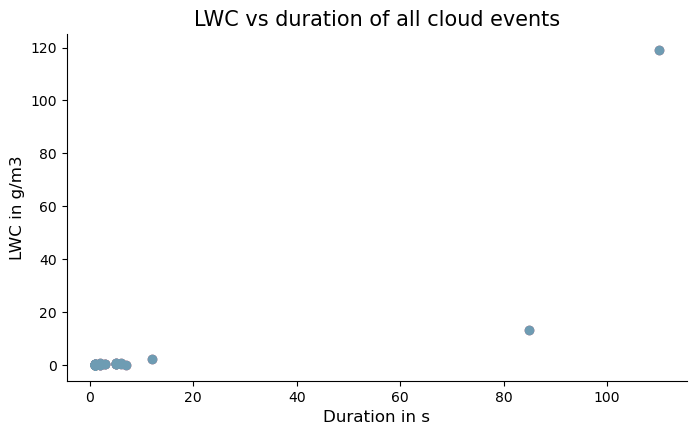

In [9]:


# Plotting relation of duration and LWC of clouds


plt.scatter(
    clouds.duration.dt.seconds.astype(int),
    clouds.liquid_water_content,
)
plt.scatter(
    clouds.duration.dt.seconds.astype(int),
    clouds.liquid_water_content,
)
plt.xlabel("Duration in s")
plt.ylabel("LWC in g/m3")
plt.title("LWC vs duration of all cloud events")


In [ ]:


# Plot map of selected clouds and realted ATR measurements and dropsondes


fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4),
    subplot_kw={"projection": ccrs.PlateCarree()},
    sharex=True,
    sharey=True,
)

gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.left_labels = False


colors = mdates.date2num(cloud_selection.time)

sc = axs[0].scatter(
    cloud_selection.lon,
    cloud_selection.lat,
    c=colors,
    cmap="plasma",
)
loc = mdates.AutoDateLocator()
cbar = plt.colorbar(
    mappable=sc,
    ax=axs[0],
    label="Time",
    ticks=loc,
    format=mdates.AutoDateFormatter(loc, defaultfmt="%y-%m-%d"),
    orientation="horizontal",
)
cbar.ax.tick_params(rotation=-35)

colors = cloud_selection.alt

sc = axs[1].scatter(
    cloud_selection.lon,
    cloud_selection.lat,
    c=colors,
    cmap="plasma",
)
plt.colorbar(mappable=sc, ax=axs[1], label="Altitude in m", orientation="horizontal")

fig.suptitle(f"{head_number} identified clouds with longest duration", fontsize=16)

fig.savefig(fig_path / Path("identified_clouds_longest_duration.svg"), dpi=300, bbox_inches="tight")


In [ ]:


# Plot map of identified cloud and realted ATR measurements and dropsondes

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4),
    subplot_kw={"projection": ccrs.PlateCarree()},
    sharex=True,
    sharey=True,
)

gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.left_labels = False

sorted_ds = identified_clouds.sortby(identified_clouds.duration)
sorted_ds = sorted_ds.isel(time=slice(-head_number, None))
colors = mdates.date2num(sorted_ds.time)

sc = axs[0].scatter(
    sorted_ds.lon,
    sorted_ds.lat,
    c=colors,
    cmap="plasma",
)
loc = mdates.AutoDateLocator()
cbar = plt.colorbar(
    mappable=sc,
    ax=axs[0],
    label="Time",
    ticks=loc,
    format=mdates.AutoDateFormatter(loc, defaultfmt="%y-%m-%d"),
    orientation="horizontal",
)
cbar.ax.tick_params(rotation=-35)

colors = sorted_ds.alt

sc = axs[1].scatter(
    sorted_ds.lon,
    sorted_ds.lat,
    c=colors,
    cmap="plasma",
)
plt.colorbar(mappable=sc, ax=axs[1], label="Altitude in m", orientation="horizontal")

fig.suptitle(f"{head_number} identified clouds with longest duration", fontsize=16)

fig.savefig(fig_path / Path("identified_clouds_longest_duration_mean.svg"), dpi=300, bbox_inches="tight")


In [ ]:

# Chosing and individual cloud


chosen_id = 77

# extract the cloud
single_cloud = identified_clouds.sel(time=identified_clouds.cloud_id == chosen_id)
# realted ATR measurements
chosen_cloud_composite = cloud_composite.sel(
    time=slice(single_cloud.start[0], single_cloud.end[0]), drop=True
)

# Identify dropsondes which are close to the cloud

# get distance look up table for this cloud
single_distances = distance_IC_DS.sel(time_identified_clouds=single_cloud.time.data).compute()

# set the maximum distance for the dropsondes
max_spatial_distance = 100  # km
max_temporal_distance = np.timedelta64(1, "h")

# select the time of the dropsondes which are close to the cloud
allowed_dropsonde_times = single_distances.where(
    (np.abs(single_distances.temporal_distance) <= max_temporal_distance)
    & (single_distances.spatial_distance <= max_spatial_distance),
    drop=True,
).time_drop_sondes.compute()

# select the dropsondes which are close to the cloud
chosen_dropsondes = drop_sondes.sel(time=allowed_dropsonde_times.data, drop=True)

# lets store the example input for the model
# chosen_dropsondes.to_netcdf(output_dir / Path(f"dropsondes_{chosen_id}.nc"))
# chosen_cloud_composite.to_netcdf(output_dir / Path(f"cloud_composite_{chosen_id}.nc"))


In [ ]:


# Plotting relation of duration and LWC of clouds


plt.scatter(
    identified_clouds.duration.dt.seconds.astype(int),
    identified_clouds.liquid_water_content,
)
plt.scatter(
    single_cloud.duration.dt.seconds.astype(int),
    single_cloud.liquid_water_content,
    marker="o",
    color="k",
)
plt.xlabel("Duration in s")
plt.ylabel("LWC in g/m3")
plt.title("LWC vs duration of all cloud events")



In [ ]:


# Plot map of identified cloud and realted ATR measurements and dropsondes


fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linestyle="--")
ax.set_extent([-60, -56, 12, 15])
# Put a background image on for nice sea rendering.
# ax.add_feature(cfeature.LAND, facecolor="w", edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.LAND)

ax.scatter(
    single_cloud.lon,
    single_cloud.lat,
    transform=ccrs.PlateCarree(),
    c=default_colors[0],
    marker="+",
    s=100,
    label=f"Cloud {chosen_id}",
)

ax.scatter(
    chosen_cloud_composite.lon,
    chosen_cloud_composite.lat,
    transform=ccrs.PlateCarree(),
    c=default_colors[0],
    marker=".",
    alpha=0.5,
    s=10,
    label=f"ATR measurments (#{chosen_cloud_composite.time.size}))",
)

ax.scatter(
    chosen_dropsondes.flight_lon,
    chosen_dropsondes.flight_lat,
    transform=ccrs.PlateCarree(),
    marker="x",
    c=default_colors[1],
    label=f"Dropsondes (#{chosen_dropsondes.time.size})",
)

ax.legend(loc="lower right")
ax.set_title(
    f"Cloud {chosen_id} ({single_cloud.time.dt.strftime('%Y/%m/%d %H:%M:%S')[0].data})\n with corresponding ATR and dropsonde release location"
)
fig.savefig(fig_path / Path(f"selected_cloud_dropsondes_{chosen_id}.svg"), bbox_inches="tight")
fig.savefig(fig_path / Path(f"selected_cloud_dropsondes_{chosen_id}.png"), dpi=300, bbox_inches="tight")


In [ ]:

# Plot the temperature profiles for the selected sondes and color them by their day of the year value


style = dict(linewidth=1.3, linestyle="-", alpha=1)

print("Plotting selected drop sondes")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), sharey=True)

axs_theta = axs[0]
axs_q = axs[1]
# ds_constraint.theta.shape
old_day = None
for i, t in enumerate(chosen_dropsondes.time):
    axs_theta.plot(
        chosen_dropsondes.theta.sel(time=t), chosen_dropsondes.alt, color=default_colors[0], **style
    )
    axs_q.plot(chosen_dropsondes.q.sel(time=t), chosen_dropsondes.alt, color=default_colors[1], **style)


for ax in axs.flatten():
    ax.axhline(single_cloud.alt, color="k", linestyle="--", label="Cloud altitude")
    ax.legend(loc="lower right")
    ax.set_ylim(0, 2000)
    ax.set_ylabel("Altitude [m]")

axs[0].set_xlim(297, 305)
axs[0].set_xlabel("Potential Temperature [K]")
axs[1].set_xlim(0, 0.025)
axs[1].set_xlabel("Specific humidity in [kg / kg]")

axs[0].set_title("Potential temperature")
axs[1].set_title("Specific humidity")

fig.suptitle(
    f"Cloud {chosen_id} ({single_cloud.time.dt.strftime('%Y/%m/%d %H:%M:%S')[0].data})\nMeasurements of related dropsonde which are close to the clouds by dx<{max_spatial_distance}km dt<{max_temporal_distance}"
)
fig.savefig(fig_path / Path(f"selected_cloud_dropsondes_profiles_{chosen_id}.svg"), bbox_inches="tight")
fig.savefig(
    fig_path / Path(f"selected_cloud_dropsondes_profiles_{chosen_id}.png"), dpi=300, bbox_inches="tight"
)


In [ ]:


# Plot the temperature profiles for the selected sondes and color them by their day of the year value


# style = dict(linewidth=1.3, linestyle="-", alpha=1)

# print("Plotting selected drop sondes")
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), sharey=True)

# axs_theta = axs[0]
# axs_q = axs[1]
# # ds_constraint.theta.shape
# old_day = None
# for i, t in enumerate(chosen_dropsondes.time):
#     axs_theta.plot(
#         chosen_dropsondes.wspd.sel(time=t), chosen_dropsondes.alt, color=default_colors[0], **style
#     )
#     axs_q.plot(chosen_dropsondes.q.sel(time=t), chosen_dropsondes.alt, color=default_colors[1], **style)


# for ax in axs.flatten():
#     ax.axhline(single_cloud.alt, color="k", linestyle="--", label="Cloud altitude")
#     ax.legend(loc="lower right")
#     ax.set_ylim(0, 2000)
#     ax.set_ylabel("Altitude [m]")

# # axs[0].set_xlim(297, 305)
# # axs[0].set_xlabel("Potential Temperature [K]")
# axs[1].set_xlim(0, 0.025)
# axs[1].set_xlabel("Specific humidity in [kg / kg]")

# axs[0].set_title("Potential temperature")
# axs[1].set_title("Specific humidity")

# # fig.suptitle(
# #     f"Cloud {chosen_id} ({single_cloud.time.dt.strftime('%Y/%m/%d %H:%M:%S')[0].data})\nMeasurements of related dropsonde which are close to the clouds by dx<{max_spatial_distance}km dt<{max_temporal_distance}"
# # )
# # fig.savefig(fig_path / Path(f"selected_cloud_dropsondes_profiles_{chosen_id}.svg"), bbox_inches="tight")
# # fig.savefig(
# #     fig_path / Path(f"selected_cloud_dropsondes_profiles_{chosen_id}.png"), dpi=300, bbox_inches="tight"
# # )


In [ ]:


# Plot the temperature profiles for the selected sondes and color them by their day of the year value


print("Plotting selected ATR measurments")
fig, axs = plt.subplots(figsize=(10, 6), ncols=2, sharex=True)

#  Plot the particle_size_distribution for all and for the selected sondes
axs[0].set_xscale("log")
axs[0].set_xlabel("Particle diameter [µm]")
axs[0].set_ylabel("Count [#/L]")
axs[0].set_title("Particle size distribution")
#  Plot the particle_size_distribution for all and for the selected sondes


psd = chosen_cloud_composite["particle_size_distribution"].where(
    (chosen_cloud_composite["particle_size_distribution"] != 0).compute(), drop=True
)
msd = chosen_cloud_composite["mass_size_distribution"].where(
    (chosen_cloud_composite["mass_size_distribution"] != 0).compute(), drop=True
)

linthresh_psd = 10 ** (np.floor(np.log10(np.abs(psd.min().values))) - 1)
linthresh_msd = 10 ** (np.floor(np.log10(np.abs(msd.min().values))) - 1)

axs[0].set_xscale("log")
symlog_psd = mpl.scale.SymmetricalLogScale(
    axs[0], base=10, linthresh=linthresh_psd, subs=None, linscale=0.2
)
axs[0].set_yscale(symlog_psd)

axs[1].set_xscale("log")
symlog_psd = mpl.scale.SymmetricalLogScale(
    axs[1], base=10, linthresh=linthresh_msd, subs=None, linscale=0.2
)
axs[1].set_yscale(symlog_psd)


axs[0].plot(
    chosen_cloud_composite.diameter,
    chosen_cloud_composite.particle_size_distribution,
    alpha=0.75,
    linewidth=0.2,
    marker=".",
    # label = f'individual measurements {q*100:.0f}th percentile based on LWC'
)

axs[1].plot(
    chosen_cloud_composite.diameter,
    chosen_cloud_composite.mass_size_distribution,
    alpha=0.75,
    linewidth=0.2,
    marker=".",
    # label = f'individual measurements {q*100:.0f}th percentile based on LWC'
)

axs[1].set_xlabel("Particle diameter [µm]")
axs[1].set_ylabel("Mass [g/L/µm]")
axs[1].set_title("Mass size distribution")

for ax in axs.flatten():
    # ax.legend()
    ax.set_ylim(0, None)


fig.suptitle(
    f"Cloud {chosen_id} ({single_cloud.time.dt.strftime('%Y/%m/%d %H:%M:%S')[0].data})\nMeasurements of ATR\n"
)
fig.tight_layout()
fig.savefig(fig_path / Path(f"selected_cloud_ATR_{chosen_id}.svg"), bbox_inches="tight")
fig.savefig(fig_path / Path(f"selected_cloud_ATR_{chosen_id}.png"), dpi=300, bbox_inches="tight")



In [ ]:

psds = chosen_cloud_composite["particle_size_distribution"].compute()


# Plot the particle size distribution


print("Plotting selected ATR measurments")
fig, ax = plt.subplots(figsize=(5, 6), ncols=1)

#  Plot the particle_size_distribution for all and for the selected sondes
ax.set_xscale("log")
ax.set_xlabel("Particle diameter [µm]")
ax.set_ylabel("Count [#/L]")
ax.set_title("Particle size distribution")
#  Plot the particle_size_distribution for all and for the selected sondes


psd = psds.where((psds != 0).compute(), drop=True)

linthresh_psd = 10 ** (np.floor(np.log10(np.abs(psd.min().values))) - 1)

ax.set_xscale("log")
symlog_psd = mpl.scale.SymmetricalLogScale(ax, base=10, linthresh=linthresh_psd, subs=None, linscale=0.2)
ax.set_yscale(symlog_psd)


ax.plot(
    psds.diameter,
    psds,
    alpha=0.15,
    linewidth=0.2,
    linestyle="none",
    marker=".",
    color="k",
)

ax.plot(
    psds.diameter,
    psds.median(dim="time"),
    alpha=0.75,
    linewidth=0.7,
    marker=".",
    color="b",
    label="median"
    # label = f'individual measurements {q*100:.0f}th percentile based on LWC'
)

ax.plot(
    psds.diameter,
    psds.mean(dim="time"),
    alpha=0.75,
    linewidth=0.7,
    marker=".",
    color="r",
    label="mean"
    # label = f'individual measurements {q*100:.0f}th percentile based on LWC'
)


ax.set_ylim(0, None)

# ax.set_xlim(1e2, 2e3)
# ax.set_ylim(6e-3, 1.5e-2)

ax.legend()

fig.suptitle(
    f"Cloud {chosen_id} ({single_cloud.time.dt.strftime('%Y/%m/%d %H:%M:%S')[0].data}) | PSD of ATR"
)
fig.savefig(fig_path / Path(f"selected_cloud_ATR_psd_{chosen_id}.svg"), bbox_inches="tight")

In [ ]:
# # %%
# # print((ds.cloud_mask == True).sum().compute())
# # print((ds.drizzle_mask == True).sum().compute())
# # print((ds.rain_mask == True).sum().compute())

# min_duration_new = 5
# cm_new = cm_org.fillna(0).astype(bool)
# cm_new = consecutive_events_xr(cm_new, min_duration = min_duration_new, axis="time")
# with ProgressBar():
#         cm_new = cm_new.compute()

# #  %%
# window_width = 10
# necessary_true = 3
# with ProgressBar():
#         cm_rolling = (cm_org.rolling(time = window_width, center = True).sum('time', center = True) >= necessary_true)
#         cm_rolling_new = (cm_new.rolling(time = window_width, center = True).sum('time', center = True) >= necessary_true)

# min_duration_rolling = 15
# cm_rolling_consecutive = consecutive_events_xr(cm_rolling, min_duration = min_duration_rolling, axis="time",)
# # %%
# print(cm_org.sum().compute())
# print(cm_rolling.sum().compute())
# print(cm_rolling_consecutive.sum().compute())
# print(cm_new.sum().compute())
# print(cm_rolling_new.sum().compute())
# # %%
# # interesting example

# temp_slice = slice("2020-01-26 18:10:10", "2020-01-26 18:11:10")

# fig, axs = plt.subplots(nrows = 5, ncols = 1, figsize=(10, 5), sharex=True, sharey=True)
# cm_org.sel(time = temp_slice).plot(ax = axs[0], marker = 'o')
# axs[0].set_title('Original cloud mask')

# for ax in axs[1:] :
#         cm_org.sel(time = temp_slice).plot(ax = ax, marker = 'o', alpha = 0.5)
# cm_rolling.sel(time = temp_slice).plot(ax = axs[1], marker = 'o')
# axs[1].set_title(f'Rolling window applied of {window_width} time steps. At least {necessary_true} time steps have to be true')

# cm_rolling_consecutive.sel(time = temp_slice).plot(ax = axs[2], marker = 'o')
# axs[2].set_title(f'Rolling selection applied. Then consecutive events of at least  15 time steps after rolling window')

# cm_new.sel(time = temp_slice).plot(ax = axs[3], marker = 'o')
# axs[3].set_title(f'Consecutive events of at least {min_duration_new} time steps')

# cm_rolling_new.sel(time = temp_slice).plot(ax = axs[4], marker = 'o')
# axs[4].set_title('consecutive events then rolling window applied')

# fig.tight_layout()
# # %%


# #  %%
# print("Plotting selected drop sondes and ATR locations")
# fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 7), subplot_kw={"projection": ccrs.PlateCarree()}, sharex=True, sharey=True)
# axs = axs.flatten()

# for ax in axs :
#     ax.gridlines(draw_labels=False)
#     ax.set_extent([-58.5, -58, 12.5, 14])


# for ax, mask, c_title in zip(
#        axs,
#        [cm_org, cm_new, cm_rolling, cm_rolling_new],
#        ["Original", "Consecutive events", "Rolling window", "Rolling window and consecutive events"]
#        ) :

#         colors = mdates.date2num(cloud_composite.time.sel(time = mask.time[mask == True]))
#         sc = ax.scatter(
#         cloud_composite.lon.sel(time = mask.time[mask == True]),
#                 cloud_composite.lat.sel(time = mask.time[mask == True]),
#                 transform=ccrs.PlateCarree(),
#                 c = colors,
#                 marker="+",
#                 cmap="plasma"
#         )
#         loc = mdates.AutoDateLocator()
#         ax.set_title(f"{c_title}\n#True: {mask.sum().compute().data}")
#         # plt.colorbar(mappable=sc, ax=ax, label="time", ticks=loc, format=mdates.AutoDateFormatter(loc), orientation="horizontal")

# fig.suptitle("Cloud identification methods", fontsize=16)
# fig.tight_layout()

# # %%
# cm = cm_org
# cloud_diff = cm.fillna(0).astype(int).diff(dim="time")
# cm.plot(marker = 'o')
# cloud_diff.plot(marker = 'o')
# cloud_start = cloud_diff.time.where(cloud_diff == 1, drop = True)
# cloud_end = cloud_diff.time.where(cloud_diff == -1, drop = True)
# # cloud_length = cloud_end cloud_start

# # %%
# identified_clouds = xr.Dataset(
#         coords = {"cloud_id": np.arange(0, cloud_start.size)},
#         data_vars = {
#                 "start": ('cloud_id', cloud_start.data),
#                 "end": ('cloud_id', cloud_end.data),
#         }
# )
# identified_clouds['duration'] = identified_clouds.end - identified_clouds.start
# identified_clouds['mid_time'] = identified_clouds.start + identified_clouds.duration/2
# identified_clouds = identified_clouds.assign_coords({'time': identified_clouds.mid_time})
# identified_clouds = identified_clouds.swap_dims({'cloud_id' : 'time'})
# identified_clouds['selection'] = ('time', [slice(start, end) for start, end in zip(identified_clouds.start.data, identified_clouds.end.data)])
# identified_clouds
# # %%

# # temp_slice = cloud_start.time.isel(time = slice(0,2))
# temp_slice = slice("2020-01-26 18:10:10", "2020-01-26 18:11:10")

# fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 5), sharex=True, sharey=True)
# cm_org.sel(time = temp_slice).plot(ax = axs[0], marker = 'o')
# axs[0].set_title('Original cloud mask')

# for ax in axs[1:] :
#         cm_org.sel(time = temp_slice).plot(ax = ax, marker = 'o', alpha = 0.5)

# cm_rolling.sel(time = temp_slice).plot(ax = axs[1], marker = 'o')
# axs[1].set_title(f'Rolling window applied of {window_width} time steps. At least {necessary_true} time steps have to be true')

# # cm_rolling_consecutive.sel(time = temp_slice).plot(ax = axs[2], marker = 'o')
# # axs[2].set_title(f'Rolling selection applied. Then consecutive events of at least  15 time steps after rolling window')

# cm_new.sel(time = temp_slice).plot(ax = axs[2], marker = 'o')
# axs[2].plot(
#         (identified_clouds.start.sel(time = temp_slice)),
#         (identified_clouds.start.sel(time = temp_slice)).astype(int) *0 + 1,
#         marker = 'X')
# axs[2].plot(
#         (identified_clouds.end.sel(time = temp_slice)),
#         (identified_clouds.start.sel(time = temp_slice)).astype(int) *0 - 1,
#         marker = 'X')
# axs[2].set_title(f'Consecutive events of at least {min_duration_new} time steps')

# for ax in axs[:-1]:
#         ax.set_xlabel("")

# # cm_rolling_new.sel(time = temp_slice).plot(ax = axs[4], marker = 'o')
# # axs[4].set_title('consecutive events then rolling window applied')

# # axs[3].plot(cloud_start.sel(time = temp_slice), cloud_start.sel(time = temp_slice).astype(int) *0 + 1, marker = 'o', color = 'red')
# # axs[3].plot(cloud_end.sel(time = temp_slice), cloud_end.sel(time = temp_slice).astype(int) *0 + 1, marker = 'o', color = 'blue')
# # cloud_start.sel(time = temp_slice).plot(ax = axs[2], marker = 'o', color = 'green')
# # cloud_end.sel(time = temp_slice).plot(ax = axs[2], marker = 'o', color = 'green')


# # %%

# temp_slice = slice("2020-01-26 17:35:10", "2020-01-26 18:11:10")

# fig, axs = plt.subplots(nrows = 5, ncols = 1, figsize=(10, 5), sharex=True, sharey=True)
# cm_org.sel(time = temp_slice).plot(ax = axs[0], marker = 'o')
# axs[0].set_title('Original cloud mask')

# for ax in axs[1:] :
#         cm_org.sel(time = temp_slice).plot(ax = ax, marker = 'o', alpha = 0.5)
# cm_rolling.sel(time = temp_slice).plot(ax = axs[1], marker = 'o')
# axs[1].set_title(f'Rolling window applied of {window_width} time steps. At least {necessary_true} time steps have to be true')

# cm_rolling_consecutive.sel(time = temp_slice).plot(ax = axs[2], marker = 'o')
# axs[2].set_title(f'Rolling selection applied. Then consecutive events of at least  15 time steps after rolling window')

# cm_new.sel(time = temp_slice).plot(ax = axs[3], marker = 'o')
# axs[3].set_title(f'Consecutive events of at least {min_duration_new} time steps')

# cm_rolling_new.sel(time = temp_slice).plot(ax = axs[4], marker = 'o')
# axs[4].set_title('consecutive events then rolling window applied')

# axs[3].plot(cloud_start.sel(time = temp_slice), cloud_start.sel(time = temp_slice).astype(int) *0 + 2, marker = 'o', color = 'red')
# axs[3].plot(cloud_end.sel(time = temp_slice), cloud_end.sel(time = temp_slice).astype(int) *0 + 2, marker = 'o', color = 'blue')

# fig.tight_layout()
# # %%
